<h1><center> <span style="color: #f2cf4a; font-family: Babas; font-size: 1.5em;">CLUSTERING BOROUGHS OF GALICIA BASED ON SOCIO-ECONOMIC INDICATORS</span>
 </center></h1>

<h1><center> Applied Data Science Capstone by IBM/Coursera </center></h1>
<h2><center> Xabier García, May 2020 </center></h2>

<img src="castro.jpg" alt="Castro de Baroña" width="1500" class="center">
<h6><left> Image 1: Castro de Baroña, A Coruña, Galicia (from Wikipedia) </left></h6>

<h1><center>  </center></h1>

# Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)



# Introduction: Business Problem <a name="introduction"></a>

Galicia is a nation in the northwest of the Spanish state. With almost 2.700.000 inhabitants, it is characterized by an extensive population throughout its territory: Galicia has half of the population centers of the Spanish state. Galician territory is organized into four provinces and currently has 313 main boroughs. As in many other countries in the world, there has been a trend of depopulation from rural to urban areas for many years. 

In this project the Galician boroughs will be analysed based on several socio-economic indicators: population, density, per capita income, population ageing, vegetative balance and unemployment rate. With this data the boroughs will be clustered using the **machine learning algorithm k-means**. The main characteristics of each group will be discussed. Finally, within each cluster, the most recommended venue categories in the centers of each boroughs are shown, using data from the **Foursquare Places API**. Trends between venue categories and socio-economic indicators will be shown.

This project can be useful for both public and private organizations to understand the demographic and economic distribution of Galician boroughs when offering services, infrastructures or any other kind of business. 


# Data <a name="data"></a>

The data sources used for this project are:


* List of galician boroughs and their population from the IGE (Galician Institute of Statistics) https://www.ige.eu/
    
   This information was previously downloaded from the web page in .csv format. Then it is readed into Pandas DataFrames from the archives. The **population**    is updated to 2019. 
    
    
* Socio-economic indicators of every Galician borough from the IGE (Galician Institute of Statistics) https://www.ige.eu/

   These indicators are directly scrapped from web tables into Pandas DataFrames using BeautifulSoup:
    
     * **Per capita income (€)**. It measures the average income earned per person in a borough in a specified year. It is calculated by dividing the borough's total income by its total population. This data is updated to 2017.

     * **Population density (population/km^2)**. It is a measurement of population per unit area. This data is updated to 2019.
     
     * **Unemployment rate**. The unemployment rate used is the number of unemployed people divided by the population. This data is updated 2019.
     
     * **Vegetative balance**. It is the difference between births and deaths of a given population, divided by the total population. This data is updated to 2018.
     
     * **Population ageing (%)**. It is the relationship between the population over the age of 64 and the population under the age of 20 expressed in %. This data is updated to 2019.

  With all these indicators the boroughs will be clustered into several groups using a k-means algorithm. These clusters and their characteristics will allow to understand the socioeconomic distribution of the Galician population along the territory.
    
* Coordinates of the Galician boroughs from GeoPy https://geopy.readthedocs.io/
    
    The GeoPy API is used to automatically geocode the address of each borough. Maps will be plotted with Folium using these coordinates, to have a clearer idea of how the clusters are distributed. Also the characteristics of each borough will be shown with Popups on the map.  
    
* Recommended venues in the center of each Galician borough, using the Foursquare Places API https://developer.foursquare.com/places

    The top **recommended venues** are obtained for each borough with the Foursquare Places API, exploring the addresses with a radius of two kilometers. This information includes the name, location and primary category of each venue. Then the venues are grouped by main characteristics and borough clusters. A graph will be plotted to show which main characteristics of venues are more common in the different clusters.

 
    

Let's start with the code:


In [3]:
#importing libraries

import pandas as pd
import numpy as np

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from pandas.io.html import read_html

import json # library to handle JSON files

import requests

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from bs4 import BeautifulSoup
import unicodedata

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h1><center>  </center></h1>
First the .csv archives with the boroughs and population are readed into Pandas DataFrames.
The .csv archives were previously downloaded from the IGE (Galician Institute of Statistics).
There is a .csv for each province of Galicia:

<h1><center>  </center></h1>

In [4]:
#reading boroughs and population from Galicia into Pandas DataFrames

df_coruna = pd.read_csv('acoruna.csv',sep=";",header=None)
df_lugo = pd.read_csv('lugo.csv',sep=";",header=None)
df_ourense = pd.read_csv('ourense.csv',sep=";",header=None)
df_pontevedra = pd.read_csv('pontevedra.csv',sep=";",header=None)


In [5]:
#adding a new column with the name of the province

df_coruna['Province']="Coruna, A"
df_lugo['Province']="Lugo"
df_ourense['Province']="Ourense"
df_pontevedra['Province']="Pontevedra"

In [6]:
#concatenate the four DataFrames into one

frames = [df_coruna,df_lugo,df_pontevedra,df_ourense]

df_galicia = pd.concat(frames)

df_galicia.drop(df_galicia.columns[[3,4]], axis=1,inplace=True)

In [7]:
#rename columns

df_galicia.columns=['INE Code','Borough','Population','Province']


In [8]:
#reset index and show the DataFrame

df_galicia.reset_index(drop=True,inplace=True)

df_galicia.head()

,INE Code,Borough,Population,Province
0,15001,Abegondo,5406,"Coruna, A"
1,15002,Ames,31793,"Coruna, A"
2,15003,Aranga,1849,"Coruna, A"
3,15004,Ares,5732,"Coruna, A"
4,15005,Arteixo,32262,"Coruna, A"


In [9]:
#check if there is any duplicated borough

df_galicia.duplicated(subset='Borough').any()

False

<h1><center>  </center></h1>

<a href="https://www.google.com"><img src="https://programacionpython80889555.files.wordpress.com/2020/03/geopy_logo.png?w=1200" width="300" align="center"></a>



Now that we have the address of each borough, let's get their coordinates using GeoPy:
<h1><center>  </center></h1>

In [10]:
#importing library

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

In [11]:
#creating new columns in DataFrame for Latitude and Longitude

df_galicia['Latitude']=0
df_galicia['Longitude']=0

df_galicia.head()

,INE Code,Borough,Population,Province,Latitude,Longitude
0,15001,Abegondo,5406,"Coruna, A",0,0
1,15002,Ames,31793,"Coruna, A",0,0
2,15003,Aranga,1849,"Coruna, A",0,0
3,15004,Ares,5732,"Coruna, A",0,0
4,15005,Arteixo,32262,"Coruna, A",0,0


In [12]:
#adding the latitude and longitude coordinates to the DataFrame using GeoPy Nominatim
#it is commented once it has been executed and the data has been saved

""""
geolocator = Nominatim(user_agent="galicia_agent")


for index,row in df_galicia.iterrows():
           
    if len(row['Borough'].split(','))>1:   
            label=row['Borough'].split(',')[1]+' '+row['Borough'].split(',')[0]+ "," + row['Province'].split(',')[0]+ "," +'Galicia'+ "," +'España'
            print(label)
    else:
            label=row['Borough'].split(',')[0]+ "," + row['Province'].split(',')[0]+ "," +'Galicia'+ "," +'España'
            print(label)
            
            
    location = geolocator.geocode(label)
    latitude = location.latitude
    longitude = location.longitude
    print(latitude,longitude)
    df_galicia.loc[index,'Latitude']=latitude
    df_galicia.loc[index,'Longitude']=longitude


df_galicia.head()

"""

'"\ngeolocator = Nominatim(user_agent="galicia_agent")\n\n\nfor index,row in df_galicia.iterrows():\n           \n    if len(row[\'Borough\'].split(\',\'))>1:   \n            label=row[\'Borough\'].split(\',\')[1]+\' \'+row[\'Borough\'].split(\',\')[0]+ "," + row[\'Province\'].split(\',\')[0]+ "," +\'Galicia\'+ "," +\'España\'\n            print(label)\n    else:\n            label=row[\'Borough\'].split(\',\')[0]+ "," + row[\'Province\'].split(\',\')[0]+ "," +\'Galicia\'+ "," +\'España\'\n            print(label)\n            \n            \n    location = geolocator.geocode(label)\n    latitude = location.latitude\n    longitude = location.longitude\n    print(latitude,longitude)\n    df_galicia.loc[index,\'Latitude\']=latitude\n    df_galicia.loc[index,\'Longitude\']=longitude\n\n\ndf_galicia.head()\n\n'

In [13]:
#save the DataFrame to .csv

#df_galicia.to_csv(index=False)

In [14]:
#importing the DataFrame saved previously

df_galicia = pd.read_csv('df_galicia.csv')
df_galicia.head()


,INE Code,Borough,Population,Province,Latitude,Longitude
0,15001,Abegondo,5406,"Coruna, A",43.210443,-8.290324
1,15002,Ames,31793,"Coruna, A",42.890030,-8.651627
2,15003,Aranga,1849,"Coruna, A",43.218390,-8.015691
3,15004,Ares,5732,"Coruna, A",43.426330,-8.244039
4,15005,Arteixo,32262,"Coruna, A",43.309653,-8.500338


In [15]:
#checking the number of boroughs of Galicia

df_galicia.shape

(313, 6)

<h1><center>  </center></h1>
Finally we have a DataFrame with the coordinates and population of the 313 boroughs of Galicia. 

<h1><center>  </center></h1>

<h1><center>  </center></h1>

<a href="https://www.google.com"><img src="https://upload.wikimedia.org/wikipedia/commons/d/dc/Foursquare_logo.svg" width="300" align="center"></a>


Now let's get the recommended venues of each borough with the Foursquare API. They are saved into a DataFrame with name, primary category and location. 

<h1><center>  </center></h1>

Foursquare credentials are defined in hidden cell bellow.

In [16]:
# @hidden_cell

In [17]:
# This is a function to get the top venues that are in every borough in a radius of 2 km

def getNearbyVenues(ine_code,names, latitudes, longitudes, radius=2000):
    

    venues_list=[]
    addresses=[]
    exception =[]
    
    for index,row in df_galicia_busqueda.iterrows():
           
            label=row['Borough'] + "," +' Galicia'+ "," +' España'
            addresses.append(label)
            
    for ine, name, lat, lng,address in zip(ine_code, names, latitudes, longitudes,addresses):
        
          
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        address,
        radius,    
        LIMIT) 
            
        # make the GET request
               
        try:
            print(address)
            getresults = requests.get(url).json()
            
            results = getresults["response"]['groups'][0]['items']
            
            latitude = getresults["response"]["geocode"]["center"]["lat"]
            longitude = getresults["response"]["geocode"]["center"]["lng"]
        
        except:
            
            exception.append(name)
            results=[]
            pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            ine,
            name, 
            latitude, 
            longitude, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['INE Code',
                  'Borough',
                  'FQ borough Latitude', 
                  'FQ borough Longitude',             
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print(exception)
    return(nearby_venues)

In [18]:
#The Foursquare API did not recognize some addresses. They are renamed:

df_galicia_busqueda = df_galicia.copy()

coruña = df_galicia_busqueda[df_galicia_busqueda['Borough'].str.contains('Coruña')].index

df_galicia_busqueda.loc[coruña,'Borough']="Coruña"

porriño = df_galicia_busqueda[df_galicia_busqueda['Borough'].str.contains('Porriño')].index

df_galicia_busqueda.loc[porriño,'Borough']="Porriño"


In [19]:
#This cell calls the function to get the venues.
#it is commented once it has been executed and the data has been saved

"""
LIMIT=100

galicia_venues = getNearbyVenues( ine_code=df_galicia_busqueda['INE Code'],
                                    names=df_galicia_busqueda['Borough'],
                                   latitudes=df_galicia_busqueda['Latitude'],
                                   longitudes=df_galicia_busqueda['Longitude']
                                  )
                           
"""

"\nLIMIT=100\n\ngalicia_venues = getNearbyVenues( ine_code=df_galicia_busqueda['INE Code'],\n                                    names=df_galicia_busqueda['Borough'],\n                                   latitudes=df_galicia_busqueda['Latitude'],\n                                   longitudes=df_galicia_busqueda['Longitude']\n                                  )\n                           \n"

In [20]:
#save the venues data to a .csv

#galicia_venues.to_csv('galicia_venues.csv',index=False)

In [21]:
#importing the DataFrame saved previously

galicia_venues = pd.read_csv('galicia_venues.csv')
galicia_venues.head()


,INE Code,Borough,FQ borough Latitude,FQ borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,15001,Abegondo,43.21667,-8.28333,Oza Paradise,43.211984,-8.278352,Skate Park
1,15001,Abegondo,43.21667,-8.28333,Meson San Marcos,43.226690,-8.288709,Brewery
2,15001,Abegondo,43.21667,-8.28333,Supermercado das Mariñas,43.217842,-8.299469,Grocery Store
3,15001,Abegondo,43.21667,-8.28333,Momentos,43.229025,-8.287383,Bar
4,15001,Abegondo,43.21667,-8.28333,Cafetería Gala,43.229663,-8.288057,Café


In [22]:
#checking the number of venues imported

print(galicia_venues.shape)

(3231, 8)


<h1><center>  </center></h1>

The venues that were imported are only described by their primary category (such as 'italian restaurant'). We are going to classify them by their main category: Arts & Entertainment, College & University, Food, Nightlife Spot, Outdoors & Recreation, Professional & Other Places, Shop & Service, Travel & Transport.

<br> For that we import the Foursquare Venue Category Hierarchy, and them transform every primary category into the main category.

<h1><center>  </center></h1>

In [23]:
#importing the Foursquare Venue Category Hierarchy
#it is commented once it has been executed and the data has been saved

"""

# create the API request URL
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
CLIENT_ID, 
CLIENT_SECRET,
VERSION) 
            
# make the GET request
               
categories = requests.get(url).json()

"""

"\n\n# create the API request URL\nurl = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(\nCLIENT_ID, \nCLIENT_SECRET,\nVERSION) \n            \n# make the GET request\n               \ncategories = requests.get(url).json()\n\n"

In [24]:
#transform the categories .json file imported previously into a pandas dataframe
#it is commented once it has been executed and the data has been saved

"""
cat = categories['response']['categories']

first=[]
second=[]
third=[]
fourth=[]


for v in cat:

        for h in v['categories']:
            
            
            if len(h['categories']) >0:
            
                for j in h['categories']:
                    
                    if len(j['categories']) >0:
                        
                        for z in j['categories']:
            
                            first.append(v['name'])
                            second.append(h['name'])
                            third.append(j['name'])
                            fourth.append(z['name'])
                        
                    else:
                    
                            first.append(v['name'])
                            second.append(h['name'])
                            third.append(j['name'])
                            fourth.append(j['name'])
                    
           
            else:
                
                    first.append(v['name'])
                    second.append(h['name'])
                    third.append(h['name'])
                    fourth.append(h['name'])

dict_categories={'Main category':first,'2nd Category':second,'3rd Category':third,'4th Category':fourth}


df_categories=pd.DataFrame(dict_categories)


df_categories.head()

"""

"\ncat = categories['response']['categories']\n\nfirst=[]\nsecond=[]\nthird=[]\nfourth=[]\n\n\nfor v in cat:\n\n        for h in v['categories']:\n            \n            \n            if len(h['categories']) >0:\n            \n                for j in h['categories']:\n                    \n                    if len(j['categories']) >0:\n                        \n                        for z in j['categories']:\n            \n                            first.append(v['name'])\n                            second.append(h['name'])\n                            third.append(j['name'])\n                            fourth.append(z['name'])\n                        \n                    else:\n                    \n                            first.append(v['name'])\n                            second.append(h['name'])\n                            third.append(j['name'])\n                            fourth.append(j['name'])\n                    \n           \n            else:\n        

In [25]:
#save the dataframe to .csv

#df_categories.to_csv(index=False)

In [26]:
#importing the .csv saved previously

df_categories = pd.read_csv('df_categories.csv')
df_categories.head()

,Main category,2nd Category,3rd Category,4th Category
0,Arts & Entertainment,Amphitheater,Amphitheater,Amphitheater
1,Arts & Entertainment,Aquarium,Aquarium,Aquarium
2,Arts & Entertainment,Arcade,Arcade,Arcade
3,Arts & Entertainment,Art Gallery,Art Gallery,Art Gallery
4,Arts & Entertainment,Bowling Alley,Bowling Alley,Bowling Alley


In [27]:
#transform the venue category into main category

galicia_venues['Main Category']=0

for index,row in galicia_venues.iterrows():
           
        a= df_categories[df_categories['4th Category']==(row['Venue Category'])]
        
        if a.shape[0]>0:
        
            galicia_venues.loc[index,'Main Category']=df_categories[df_categories['4th Category']==(row['Venue Category'])].iloc[0,0]
            
        else: 
             
            b= df_categories[df_categories['3rd Category']==(row['Venue Category'])]
            
            if b.shape[0]>0:
                
                galicia_venues.loc[index,'Main Category']=df_categories[df_categories['3rd Category']==(row['Venue Category'])].iloc[0,0]
                                        
            else:
                
                c= df_categories[df_categories['2nd Category']==(row['Venue Category'])]
                
                if c.shape[0]>0:
                    
                    galicia_venues.loc[index,'Main Category']=df_categories[df_categories['2nd Category']==(row['Venue Category'])].iloc[0,0]
                    
                    
                else:
                    
                    d= df_categories[df_categories['Main category']==(row['Venue Category'])]
                    
                    if d.shape[0]>0:
                    
                        galicia_venues.loc[index,'Main Category']=df_categories[df_categories['Main category']==(row['Venue Category'])].iloc[0,0]      
                        

In [28]:
#The result is this dataframe:

galicia_venues.head()

,INE Code,Borough,FQ borough Latitude,FQ borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Main Category
0,15001,Abegondo,43.21667,-8.28333,Oza Paradise,43.211984,-8.278352,Skate Park,Outdoors & Recreation
1,15001,Abegondo,43.21667,-8.28333,Meson San Marcos,43.226690,-8.288709,Brewery,Nightlife Spot
2,15001,Abegondo,43.21667,-8.28333,Supermercado das Mariñas,43.217842,-8.299469,Grocery Store,Shop & Service
3,15001,Abegondo,43.21667,-8.28333,Momentos,43.229025,-8.287383,Bar,Nightlife Spot
4,15001,Abegondo,43.21667,-8.28333,Cafetería Gala,43.229663,-8.288057,Café,Food


In [29]:
#check if every venue has a main category

galicia_venues['Main Category'].isnull().sum()

0

In [30]:
# Create a new dataframe encoding main categroes

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# one hot encoding
galicia_onehot = pd.get_dummies(galicia_venues[['Main Category']], prefix="", prefix_sep="")


# add borough and INE code column back to dataframe
galicia_onehot['Borough'] = galicia_venues['Borough']
galicia_onehot['INE Code'] = galicia_venues['INE Code']

# move column to the first column
fixed_columns = [galicia_onehot.columns[-1]]+[galicia_onehot.columns[-2]] + list(galicia_onehot.columns[:-2])
galicia_onehot = galicia_onehot[fixed_columns]

galicia_onehot.head()

,INE Code,Borough,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,15001,Abegondo,0,0,0,0,1,0,0,0
1,15001,Abegondo,0,0,0,1,0,0,0,0
2,15001,Abegondo,0,0,0,0,0,0,1,0
3,15001,Abegondo,0,0,0,1,0,0,0,0
4,15001,Abegondo,0,0,1,0,0,0,0,0


<h1><center>  </center></h1>

Finally we have a dataframe with every borough and the frequency of ocurrence of each main category:

<h1><center>  </center></h1>

In [31]:
# Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

galicia_grouped = galicia_onehot.groupby('Borough').mean().reset_index()
galicia_grouped.head()

,Borough,INE Code,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Abadín,27001,0.000000,0.0,0.500000,0.000000,0.500000,0.0,0.000000,0.000000
1,Abegondo,15001,0.000000,0.0,0.250000,0.250000,0.125000,0.0,0.375000,0.000000
2,Agolada,36020,0.000000,0.0,0.333333,0.333333,0.333333,0.0,0.000000,0.000000
3,Alfoz,27002,0.166667,0.0,0.166667,0.333333,0.166667,0.0,0.000000,0.166667
4,Allariz,32001,0.066667,0.0,0.600000,0.200000,0.000000,0.0,0.133333,0.000000


<h1><center></center></h1>


<a href="https://www.google.com"><img src="people.jpg" width="360" align="center"></a>

<h2><left>SOCIO-ECONOMIC INDICATORS</left></h2>




Let's make the web scraping from the IGE (Galician Institute of Statistics):  

<h1><center></center></h1>


In [32]:
df_galicia.head()

,INE Code,Borough,Population,Province,Latitude,Longitude
0,15001,Abegondo,5406,"Coruna, A",43.210443,-8.290324
1,15002,Ames,31793,"Coruna, A",42.890030,-8.651627
2,15003,Aranga,1849,"Coruna, A",43.218390,-8.015691
3,15004,Ares,5732,"Coruna, A",43.426330,-8.244039
4,15005,Arteixo,32262,"Coruna, A",43.309653,-8.500338


In [33]:
#function to scrape indicators from a web table and save them into pandas dataframes

def return_indicators(page, cell, column, name,delete_first_row):

    source = requests.get(page).text

    soup = BeautifulSoup(source, 'html5lib')

    ine_code=[]
    indicators=[]

    for table_cell in soup.find_all("td",{"class": "miembroXnp"}):
    
        a=table_cell.text
        a=a.split(" ")[0]
        a = unicodedata.normalize("NFKD", a).strip()
        ine_code.append(a)
    
    
    for table in soup.find_all('table',{"class": "pequena"}):

        for el in table.find_all('tr'):
        
            i=0      
            for table_cell in el.find_all("td",{"class": cell}):    
            
                i=i+1
                if i==column:

                    a=table_cell.text
                    a = unicodedata.normalize("NFKD", a).strip()       
                    a=a.replace(".","")
                    a=a.replace(",",".")     
                    indicators.append(a)
         

    dict_indicators={'INE Code':ine_code, name:indicators}

    df_indicators=pd.DataFrame(dict_indicators)
    
    if delete_first_row:
    
        df_indicators.drop(index=0,axis=0,inplace=True)

        df_indicators.reset_index(drop=True,inplace=True)
        
        
    df_indicators['INE Code'] = df_indicators['INE Code'].astype(int)  

    return (df_indicators)

In [34]:
#executing the function for each indicator. There is a table for each province.


#Per capita income

df_income_co = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=9660&R=9913[15:15001:15002:15003:15004:15005:15006:15007:15008:15009:15010:15011:15012:15013:15014:15015:15016:15017:15018:15019:15901:15020:15021:15022:15023:15024:15025:15027:15028:15029:15030:15031:15032:15033:15034:15035:15036:15037:15038:15039:15041:15040:15042:15043:15044:15045:15046:15047:15048:15049:15050:15051:15053:15052:15054:15055:15056:15057:15058:15059:15060:15061:15062:15064:15065:15066:15067:15068:15069:15070:15071:15072:15073:15074:15075:15076:15077:15078:15079:15080:15081:15082:15083:15084:15085:15086:15088:15087:15089:15091:15090:15092:15093:15902]&C=1[all]&F=&S=0:2017&SCF='
,"celdadatoimpar", 1, 'Per capita income',True)
df_income_lu = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=9660&R=9913[27:27001:27002:27003:27004:27901:27005:27006:27007:27008:27902:27009:27010:27011:27012:27013:27016:27014:27015:27017:27018:27019:27020:27022:27023:27024:27026:27027:27028:27029:27030:27031:27032:27033:27034:27035:27037:27038:27039:27040:27041:27042:27043:27044:27045:27047:27046:27048:27049:27050:27056:27051:27052:27053:27054:27055:27057:27058:27059:27060:27061:27062:27063:27064:27065:27066:27021:27025]&C=1[all]&F=&S=0:2017&SCF='
,"celdadatoimpar", 1, 'Per capita income',True)
df_income_ou = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=9660&R=9913[32:32001:32002:32003:32004:32005:32006:32007:32008:32009:32010:32011:32012:32013:32014:32015:32016:32018:32017:32019:32020:32022:32021:32023:32024:32025:32029:32026:32027:32028:32030:32031:32033:32034:32035:32038:32039:32040:32041:32042:32043:32044:32045:32046:32047:32048:32049:32050:32051:32052:32053:32054:32055:32056:32057:32058:32059:32060:32061:32063:32064:32062:32065:32066:32067:32068:32069:32071:32072:32073:32074:32075:32076:32070:32077:32078:32079:32080:32081:32082:32083:32084:32085:32086:32087:32088:32089:32090:32091:32092:32032:32036:32037]&C=1[all]&F=&S=0:2017&SCF='
,"celdadatoimpar", 1, 'Per capita income',True)
df_income_po = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=9660&R=9913[36:36020:36001:36003:36002:36004:36005:36006:36007:36008:36009:36010:36013:36014:36015:36016:36017:36018:36019:36021:36022:36023:36901:36024:36025:36026:36027:36028:36029:36030:36031:36032:36033:36034:36035:36036:36037:36041:36043:36042:36044:36038:36039:36040:36045:36046:36047:36048:36049:36050:36051:36052:36053:36054:36055:36056:36057:36059:36058:36060:36061]&C=1[all]&F=&S=0:2017&SCF='
,"celdadatoimpar", 1, 'Per capita income',True)

#Population density 


df_den_co = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=&COD=4705&R=9913[15001:15002:15003:15004:15005:15006:15007:15008:15009:15010:15011:15012:15013:15014:15015:15016:15017:15018:15019:15901:15020:15021:15022:15023:15024:15025:15026:15027:15028:15029:15030:15031:15032:15033:15034:15035:15036:15037:15038:15039:15041:15040:15042:15043:15044:15045:15046:15047:15048:15049:15050:15051:15053:15052:15054:15055:15056:15057:15058:15059:15060:15061:15062:15063:15064:15065:15066:15067:15068:15069:15070:15071:15072:15073:15074:15075:15076:15077:15078:15079:15080:15081:15082:15083:15084:15085:15086:15088:15087:15089:15091:15090:15092:15093]&C=1[all]&F=T[1:0]3&S=&TI=1'
,"celdadatoimpar", 1, 'Population density',False)
df_den_lu = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=&COD=4705&R=9913[27001:27002:27003:27004:27901:27005:27006:27007:27008:27902:27009:27010:27011:27012:27013:27016:27014:27015:27017:27018:27019:27020:27022:27023:27024:27026:27027:27028:27029:27030:27031:27032:27033:27034:27035:27037:27038:27039:27040:27041:27042:27043:27044:27045:27047:27046:27048:27049:27050:27056:27051:27052:27053:27054:27055:27057:27058:27059:27060:27061:27062:27063:27064:27065:27066:27021:27025]&C=1[all]&F=T[1:0]3&S=&TI=2'
,"celdadatoimpar", 1, 'Population density',False)
df_den_ou = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=&COD=4705&R=9913[32001:32002:32003:32004:32005:32006:32007:32008:32009:32010:32011:32012:32013:32014:32015:32016:32018:32017:32019:32020:32022:32021:32023:32024:32025:32029:32026:32027:32028:32030:32031:32033:32034:32035:32038:32039:32040:32041:32042:32043:32044:32045:32046:32047:32048:32049:32050:32051:32052:32053:32054:32055:32056:32057:32058:32059:32060:32061:32063:32064:32062:32065:32066:32067:32068:32069:32071:32072:32073:32074:32075:32076:32070:32077:32078:32079:32080:32081:32082:32083:32084:32085:32086:32087:32088:32089:32090:32091:32092:32032:32036:32037]&C=1[all]&F=T[1:0]3&S=&TI=3'
,"celdadatoimpar", 1, 'Population density',False)
df_den_po = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=&COD=4705&R=9913[36020:36001:36003:36002:36004:36005:36006:36007:36008:36009:36010:36011:36012:36013:36014:36015:36016:36017:36018:36019:36021:36022:36023:36901:36024:36025:36026:36027:36028:36029:36030:36031:36032:36033:36034:36035:36036:36037:36041:36043:36042:36044:36038:36039:36040:36045:36046:36047:36048:36049:36050:36051:36052:36053:36054:36055:36056:36057:36059:36058:36060:36061]&C=1[all]&F=T[1:0]3&S=&TI=4'
,"celdadatoimpar", 1, 'Population density',False)



#Unemployment

df_une_co = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=744&R=9913[15:15001:15002:15003:15004:15005:15006:15007:15008:15009:15010:15011:15012:15013:15014:15015:15016:15017:15018:15019:15901:15020:15021:15022:15023:15024:15025:15026:15027:15028:15029:15030:15031:15032:15033:15034:15035:15036:15037:15038:15039:15041:15040:15042:15043:15044:15045:15046:15047:15048:15049:15050:15051:15053:15052:15054:15055:15056:15057:15058:15059:15060:15061:15062:15063:15064:15065:15066:15067:15068:15069:15070:15071:15072:15073:15074:15075:15076:15077:15078:15079:15080:15081:15082:15083:15084:15085:15086:15088:15087:15089:15091:15090:15092:15093]&C=T[2:0];2[all]&F=1:0&S=&TI=1&NA=1'
,"celdadatopar", 2, 'Unemployment',True)
df_une_lu = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=744&R=9913[27:27001:27002:27003:27004:27901:27005:27006:27007:27008:27902:27009:27010:27011:27012:27013:27016:27014:27015:27017:27018:27019:27020:27022:27023:27024:27026:27027:27028:27029:27030:27031:27032:27033:27034:27035:27037:27038:27039:27040:27041:27042:27043:27044:27045:27047:27046:27048:27049:27050:27056:27051:27052:27053:27054:27055:27057:27058:27059:27060:27061:27062:27063:27064:27065:27066:27021:27025]&C=T[2:0];2[all]&F=1:0&S=&TI=2&NA=1'
,"celdadatopar", 2, 'Unemployment',True)
df_une_ou = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=744&R=9913[32:32001:32002:32003:32004:32005:32006:32007:32008:32009:32010:32011:32012:32013:32014:32015:32016:32018:32017:32019:32020:32022:32021:32023:32024:32025:32029:32026:32027:32028:32030:32031:32033:32034:32035:32038:32039:32040:32041:32042:32043:32044:32045:32046:32047:32048:32049:32050:32051:32052:32053:32054:32055:32056:32057:32058:32059:32060:32061:32063:32064:32062:32065:32066:32067:32068:32069:32071:32072:32073:32074:32075:32076:32070:32077:32078:32079:32080:32081:32082:32083:32084:32085:32086:32087:32088:32089:32090:32091:32092:32032:32036:32037]&C=T[2:0];2[all]&F=1:0&S=&TI=3&NA=1'
,"celdadatopar", 2, 'Unemployment',True)
df_une_po = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=744&R=9913[36:36020:36001:36003:36002:36004:36005:36006:36007:36008:36009:36010:36011:36012:36013:36014:36015:36016:36017:36018:36019:36021:36022:36023:36901:36024:36025:36026:36027:36028:36029:36030:36031:36032:36033:36034:36035:36036:36037:36041:36043:36042:36044:36038:36039:36040:36045:36046:36047:36048:36049:36050:36051:36052:36053:36054:36055:36056:36057:36059:36058:36060:36061]&C=T[2:0];2[all]&F=1:0&S=&TI=4&NA=1'
,"celdadatopar", 2, 'Unemployment',True)

#Vegetative balance

df_veg_co = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=227&R=9913[15001:15002:15003:15004:15005:15006:15007:15008:15009:15010:15011:15012:15013:15014:15015:15016:15017:15018:15019:15901:15020:15021:15022:15023:15024:15025:15026:15027:15028:15029:15030:15031:15032:15033:15034:15035:15036:15037:15038:15039:15041:15040:15042:15043:15044:15045:15046:15047:15048:15049:15050:15051:15053:15052:15054:15055:15056:15057:15058:15059:15060:15061:15062:15063:15064:15065:15066:15067:15068:15069:15070:15071:15072:15073:15074:15075:15076:15077:15078:15079:15080:15081:15082:15083:15084:15085:15086:15088:15087:15089:15091:15090:15092:15093]&C=1[0:1:2];T[3:0]&F=&S=&TI=4'
,"celdadatoimpar", 5, 'Vegetative balance',False)
df_veg_lu = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=227&R=9913[27001:27002:27003:27004:27901:27005:27006:27007:27008:27902:27009:27010:27011:27012:27013:27016:27014:27015:27017:27018:27019:27020:27022:27023:27024:27026:27027:27028:27029:27030:27031:27032:27033:27034:27035:27037:27038:27039:27040:27041:27042:27043:27044:27045:27047:27046:27048:27049:27050:27056:27051:27052:27053:27054:27055:27057:27058:27059:27060:27061:27062:27063:27064:27065:27066:27021:27025]&C=1[0:1:2];T[3:0]&F=&S=&TI=5'
,"celdadatoimpar", 5, 'Vegetative balance',False)
df_veg_ou = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=227&R=9913[32001:32002:32003:32004:32005:32006:32007:32008:32009:32010:32011:32012:32013:32014:32015:32016:32018:32017:32019:32020:32022:32021:32023:32024:32025:32029:32026:32027:32028:32030:32031:32033:32034:32035:32038:32039:32040:32041:32042:32043:32044:32045:32046:32047:32048:32049:32050:32051:32052:32053:32054:32055:32056:32057:32058:32059:32060:32061:32063:32064:32062:32065:32066:32067:32068:32069:32071:32072:32073:32074:32075:32076:32070:32077:32078:32079:32080:32081:32082:32083:32084:32085:32086:32087:32088:32089:32090:32091:32092:32032:32036:32037]&C=1[0:1:2];T[3:0]&F=&S=&TI=6'
,"celdadatoimpar", 5, 'Vegetative balance',False)
df_veg_po = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=227&R=9913[36020:36001:36003:36002:36004:36005:36006:36007:36008:36009:36010:36011:36012:36013:36014:36015:36016:36017:36018:36019:36021:36022:36023:36901:36024:36025:36026:36027:36028:36029:36030:36031:36032:36033:36034:36035:36036:36037:36041:36043:36042:36044:36038:36039:36040:36045:36046:36047:36048:36049:36050:36051:36052:36053:36054:36055:36056:36057:36059:36058:36060:36061]&C=1[0:1:2];T[3:0]&F=&S=&TI=7'
,"celdadatoimpar", 5, 'Vegetative balance',False)


#Population ageing


df_age_co = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=723&R=9913[15:15001:15002:15003:15004:15005:15006:15007:15008:15009:15010:15011:15012:15013:15014:15015:15016:15017:15018:15019:15901:15020:15021:15022:15023:15024:15025:15026:15027:15028:15029:15030:15031:15032:15033:15034:15035:15036:15037:15038:15039:15041:15040:15042:15043:15044:15045:15046:15047:15048:15049:15050:15051:15053:15052:15054:15055:15056:15057:15058:15059:15060:15061:15062:15063:15064:15065:15066:15067:15068:15069:15070:15071:15072:15073:15074:15075:15076:15077:15078:15079:15080:15081:15082:15083:15084:15085:15086:15088:15087:15089:15091:15090:15092:15093]&C=1[0:10:3:6:7]&F=T[1:0];2:2&S=&TI=2'
,"celdadatoimpar", 2, 'Population ageing',True)
df_age_lu = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=723&R=9913[27:27001:27002:27003:27004:27901:27005:27006:27007:27008:27902:27009:27010:27011:27012:27013:27016:27014:27015:27017:27018:27019:27020:27022:27023:27024:27026:27027:27028:27029:27030:27031:27032:27033:27034:27035:27037:27038:27039:27040:27041:27042:27043:27044:27045:27047:27046:27048:27049:27050:27056:27051:27052:27053:27054:27055:27057:27058:27059:27060:27061:27062:27063:27064:27065:27066:27021:27025]&C=1[0:10:3:6:7]&F=T[1:0];2:2&S=&TI=3'
,"celdadatoimpar", 2, 'Population ageing',True)
df_age_po = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=723&R=9913[36:36020:36001:36003:36002:36004:36005:36006:36007:36008:36009:36010:36011:36012:36013:36014:36015:36016:36017:36018:36019:36021:36022:36023:36901:36024:36025:36026:36027:36028:36029:36030:36031:36032:36033:36034:36035:36036:36037:36041:36043:36042:36044:36038:36039:36040:36045:36046:36047:36048:36049:36050:36051:36052:36053:36054:36055:36056:36057:36059:36058:36060:36061]&C=1[0:10:3:6:7]&F=T[1:0];2:2&S=&TI=5'
,"celdadatoimpar", 2, 'Population ageing',True)
df_age_ou = return_indicators('https://www.ige.eu/igebdt/esqv.jsp?paxina=001&c=0501&ruta=verPpalesResultados.jsp?OP=1&B=1&M=1&COD=723&R=9913[32:32001:32002:32003:32004:32005:32006:32007:32008:32009:32010:32011:32012:32013:32014:32015:32016:32018:32017:32019:32020:32022:32021:32023:32024:32025:32029:32026:32027:32028:32030:32031:32033:32034:32035:32038:32039:32040:32041:32042:32043:32044:32045:32046:32047:32048:32049:32050:32051:32052:32053:32054:32055:32056:32057:32058:32059:32060:32061:32063:32064:32062:32065:32066:32067:32068:32069:32071:32072:32073:32074:32075:32076:32070:32077:32078:32079:32080:32081:32082:32083:32084:32085:32086:32087:32088:32089:32090:32091:32092:32032:32036:32037]&C=1[0:10:3:6:7]&F=T[1:0];2:2&S=&TI=4'
,"celdadatoimpar", 2, 'Population ageing',True)


In [35]:
#concatening the dataframes 

#Per capita income 2017
df_income = pd.concat([df_income_co,df_income_lu,df_income_ou,df_income_po]).reset_index(drop=True)

#Population density 2019
df_den = pd.concat([df_den_co,df_den_lu,df_den_ou,df_den_po]).reset_index(drop=True)

#Unemployment 2019
df_une = pd.concat([df_une_co,df_une_lu,df_une_ou,df_une_po]).reset_index(drop=True)

#Vegetative balance 2018
df_veg = pd.concat([df_veg_co,df_veg_lu,df_veg_ou,df_veg_po]).reset_index(drop=True)

#Population ageing 2019
df_age = pd.concat([df_age_co,df_age_lu,df_age_ou,df_age_po]).reset_index(drop=True)

<h1><center></center></h1>

Now we make some steps for data wrangling:

<h1><center></center></h1>


In [36]:
#check if there are null values and convert to float

print(df_income['Per capita income'].isnull().any())
df_income['Per capita income']=df_income['Per capita income'].astype(float)
df_income.head()

False


,INE Code,Per capita income
0,15001,14249.0
1,15002,15727.0
2,15003,11668.0
3,15004,13815.0
4,15005,13811.0


In [37]:
#check if there are null values and convert to float

df_den.drop(df_den[df_den['Population density'].str.contains("-")].index,inplace=True)

df_den['Population density']=df_den['Population density'].astype(float)

df_den.head()

,INE Code,Population density
0,15001,64.1
1,15002,394.1
2,15003,15.7
3,15004,319.7
4,15005,347.8


In [38]:
#check if there are null values and convert to int

df_une.drop(df_une[df_une['Unemployment'].str.contains("-")].index,inplace=True)

df_une['Unemployment']=df_une['Unemployment'].astype(int)

df_une.head()

,INE Code,Unemployment
0,15001,233
1,15002,1791
2,15003,49
3,15004,372
4,15005,2040


In [39]:
#check if there are null values and convert to float

df_age.drop(df_age[df_age['Population ageing'].str.contains("-")].index,inplace=True)

df_age['Population ageing']=df_age['Population ageing'].astype(float)

df_age.head()

,INE Code,Population ageing
0,15001,233.03
1,15002,54.67
2,15003,510.37
3,15004,167.80
4,15005,81.88


In [40]:
#check if there are null values and convert to float

df_veg.drop(df_veg.index[[26,63,264,265]],axis=0,inplace=True)

df_veg['Vegetative balance'] = df_veg['Vegetative balance'].astype(int)

df_veg.head()

,INE Code,Vegetative balance
0,15001,-75
1,15002,92
2,15003,-32
3,15004,-26
4,15005,55


<h1><center></center></h1>

The indicators are merged with the initial dataframe of boroughs and population:

<h1><center></center></h1>

In [41]:
#merging dataframes

df_final = df_galicia.merge(df_income,how='left',on='INE Code').merge(df_den,how='left',on='INE Code').merge(df_age,how='left',on='INE Code').merge(df_veg,how='left',on='INE Code').merge(df_une,how='left',on='INE Code')

df_final.head()

,INE Code,Borough,Population,Province,Latitude,Longitude,Per capita income,Population density,Population ageing,Vegetative balance,Unemployment
0,15001,Abegondo,5406,"Coruna, A",43.210443,-8.290324,14249.0,64.1,233.03,-75.0,233.0
1,15002,Ames,31793,"Coruna, A",42.890030,-8.651627,15727.0,394.1,54.67,92.0,1791.0
2,15003,Aranga,1849,"Coruna, A",43.218390,-8.015691,11668.0,15.7,510.37,-32.0,49.0
3,15004,Ares,5732,"Coruna, A",43.426330,-8.244039,13815.0,319.7,167.80,-26.0,372.0
4,15005,Arteixo,32262,"Coruna, A",43.309653,-8.500338,13811.0,347.8,81.88,55.0,2040.0


In [42]:
#check if there are null values and drop rows:


print(df_final[df_final.isnull().any(1)]['Borough'])

df_final.dropna(axis=0,inplace=True)

df_final.reset_index(drop=True,inplace=True)


62          Oza-Cesuras
171    Cerdedo-Cotobade
Name: Borough, dtype: object


In [43]:
#Divide these indicators by the population:

df_final['Unemployment rate']=df_final['Unemployment']/df_final['Population']

df_final['Vegetative balance']=df_final['Vegetative balance']/df_final['Population']


<h1><center></center></h1>

This concludes the data gathering phase. As a result we have two Pandas DataFrames:


* df_final: DataFrame with every borough and their indicators.

* galicia_grouped: DataFrame with every borough and the frequency of ocurrence of each main category.



In [44]:
df_final.head()

,INE Code,Borough,Population,Province,Latitude,Longitude,Per capita income,Population density,Population ageing,Vegetative balance,Unemployment,Unemployment rate
0,15001,Abegondo,5406,"Coruna, A",43.210443,-8.290324,14249.0,64.1,233.03,-0.013873,233.0,0.043100
1,15002,Ames,31793,"Coruna, A",42.890030,-8.651627,15727.0,394.1,54.67,0.002894,1791.0,0.056333
2,15003,Aranga,1849,"Coruna, A",43.218390,-8.015691,11668.0,15.7,510.37,-0.017307,49.0,0.026501
3,15004,Ares,5732,"Coruna, A",43.426330,-8.244039,13815.0,319.7,167.80,-0.004536,372.0,0.064899
4,15005,Arteixo,32262,"Coruna, A",43.309653,-8.500338,13811.0,347.8,81.88,0.001705,2040.0,0.063232


In [45]:
galicia_grouped.head()

,Borough,INE Code,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Abadín,27001,0.000000,0.0,0.500000,0.000000,0.500000,0.0,0.000000,0.000000
1,Abegondo,15001,0.000000,0.0,0.250000,0.250000,0.125000,0.0,0.375000,0.000000
2,Agolada,36020,0.000000,0.0,0.333333,0.333333,0.333333,0.0,0.000000,0.000000
3,Alfoz,27002,0.166667,0.0,0.166667,0.333333,0.166667,0.0,0.000000,0.166667
4,Allariz,32001,0.066667,0.0,0.600000,0.200000,0.000000,0.0,0.133333,0.000000


# Methodology <a name="methodology"></a>

### Exploratory data analysis

In [46]:
#show the number of boroughs of each province

df_galicia.groupby('Province').count()['Borough']

Province
Coruna, A     93
Lugo          67
Ourense       92
Pontevedra    61
Name: Borough, dtype: int64

In [47]:
#show the population of each province

df_galicia.groupby('Province').sum()['Population']

Province
Coruna, A     1119596
Lugo           329587
Ourense        307651
Pontevedra     942665
Name: Population, dtype: int64

In [48]:
#show the total population of Galicia

df_galicia['Population'].sum()

2699499

A Folium map is plotted representing the boroughs colored by province. The popups in the circle markers show the name and province of each borough:

In [49]:
#get the coordinates from mean of df_galicia

latitude = df_galicia['Latitude'].mean()
longitude = df_galicia['Longitude'].mean()
Provinces = df_galicia['Province'].unique().tolist()


Colors_dict={Provinces[0]:'#31cc77',Provinces[1]:'#3186cc',Provinces[2]:'#F44336',Provinces[3]:'#FFB300'}

# create map of Galicia using latitude and longitude values and zoom 7
map_galicia = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
for lat, lng, borough, province in zip(df_galicia['Latitude'], df_galicia['Longitude'], df_galicia['Borough'], df_galicia['Province']):
    label = '{}, {}'.format(borough, province)
    iframe = folium.IFrame(html=label, width=100, height=100)
    label = folium.Popup(iframe, parse_html=False)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=Colors_dict[province],
        fill=True,
        fill_color=Colors_dict[province],
        fill_opacity=0.7).add_to(map_galicia)  
    
map_galicia

<h1><center>  </center></h1>

The following map shows the boroughs with more than 23,000 inhabitants. These are 19 (from 313) boroughs that represent almost the 50% of the population of Galicia. Let's see the heat map:

<h1><center>  </center></h1>

In [50]:
#select boroughs with more than 23,000

df_galicia_top = df_galicia[df_galicia['Population']>23000]

print('There are:' , df_galicia_top.shape[0] , 'boroughs with more than 23,000 inhabitants')

print('It represents the:',round((df_galicia_top['Population'].sum()/df_galicia['Population'].sum())*100,2),'% of the Galician population')

There are: 19 boroughs with more than 23,000 inhabitants
It represents the: 50.42 % of the Galician population


In [51]:
#get the coordinates 

latitude = df_galicia_top['Latitude'].mean()
longitude = df_galicia_top['Longitude'].mean()

data_heat = df_galicia_top[['Latitude','Longitude','Population']].values.tolist()

# create map of Galicia using latitude and longitude values and zoom 8
map_top = folium.Map(location=[latitude, longitude],zoom_start=8)

# add markers to map

"""
for lat, lng, borough, province in zip(df_galicia_top['Latitude'], df_galicia_top['Longitude'], df_galicia_top['Borough'], df_galicia_top['Province']):
    label = '{}, {}'.format(borough, province)
    iframe = folium.IFrame(html=label, width=100, height=100)
    label = folium.Popup(iframe, parse_html=False)
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_top)  

"""
import folium.plugins as plugins    
plugins.HeatMap(data_heat).add_to(map_top)    
    
map_top

<h1><center>  </center></h1>

But Galicia is characterized by an extensive population throughout its territory, as it has been said before. The following map shows the boroughs with less than 23,000 inhabitants. These are 294 (from 313) boroughs that represent almost the 50% of the population of Galicia. Let's see the heat map:

<h1><center>  </center></h1>

In [52]:
#select boroughs with less than 23,000

df_galicia_tail = df_galicia[df_galicia['Population']<23000]

print('There are:' , df_galicia_tail.shape[0] , 'boroughs with less than 23,000 inhabitants')

print('It represents the:',round((df_galicia_tail['Population'].sum()/df_galicia['Population'].sum())*100,2),'% of the Galician population')

There are: 294 boroughs with less than 23,000 inhabitants
It represents the: 49.58 % of the Galician population


In [53]:
#get the coordinates 

latitude = df_galicia_tail['Latitude'].mean()
longitude = df_galicia_tail['Longitude'].mean()

data_heat = df_galicia_tail[['Latitude','Longitude','Population']].values.tolist()

# create map of Galicia using latitude and longitude values and zoom 8
map_top = folium.Map(location=[latitude, longitude],zoom_start=8)

# add markers to map

"""
for lat, lng, borough, province in zip(df_galicia_top['Latitude'], df_galicia_top['Longitude'], df_galicia_top['Borough'], df_galicia_top['Province']):
    label = '{}, {}'.format(borough, province)
    iframe = folium.IFrame(html=label, width=100, height=100)
    label = folium.Popup(iframe, parse_html=False)
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_top)  

"""
import folium.plugins as plugins    
plugins.HeatMap(data_heat).add_to(map_top)    
    
map_top

<h1><center>  </center></h1>

This is the summary of the socio-economic indicators:

<br> There is a great dispersion both in population and population density (from small boroughs to big cities). Population ageing and vegetative balance also vary probably due to the difference between urban and rural areas. Unemployment ranges from boroughs of 2% to a maximum of 12,5%, and and the values of per capita income range from 5,638 to 22,545€ (this indicates large differences in economic activity). 

<br>The average of the vegetative balance is negative, which explains that there is a trend in Galicia to population ageing (the average of the population ageing indicates a relation of 3,73 to 1 between old people and young people, with boroughs up to 13 to 1).

<br> This already indicates that there are great differences between the Galician municipalities, which we will try to cluster later.

<h1><center>  </center></h1>

In [54]:
df_final.loc[:,('Per capita income','Population','Population ageing','Population density','Vegetative balance','Unemployment rate')].describe()

,Per capita income,Population,Population ageing,Population density,Vegetative balance,Unemployment rate
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,12146.736334,8645.334405,373.759871,144.487460,-0.012983,0.050193
std,2043.062722,24737.708045,245.556658,426.313074,0.008448,0.015649
min,5638.000000,215.000000,54.670000,3.100000,-0.048964,0.020249
25%,10829.000000,1468.500000,171.930000,18.450000,-0.018156,0.038270
50%,12019.000000,3002.000000,311.460000,37.600000,-0.012227,0.048891
75%,13319.000000,6636.500000,523.950000,114.450000,-0.006496,0.060242
max,22545.000000,295364.000000,1333.060000,6408.700000,0.003225,0.125581


<h1><center>  </center></h1>

And their representation with box plots:

<h1><center>  </center></h1>

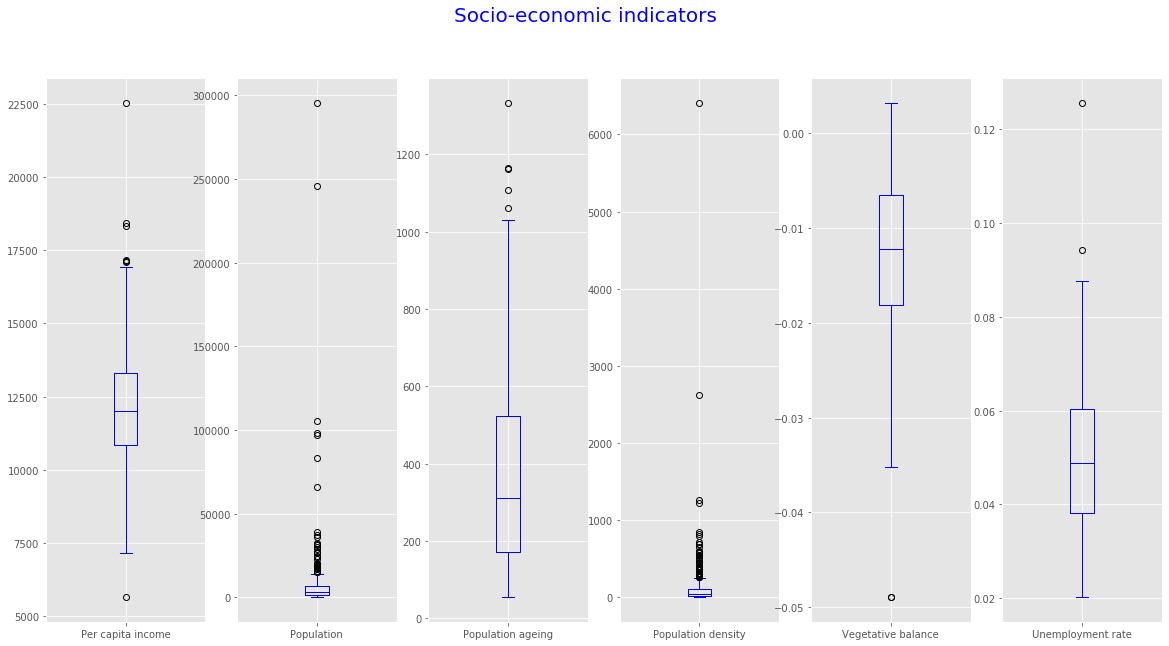

In [55]:
fig=plt.figure()

fig.suptitle('Socio-economic indicators', fontsize=20,color='blue')
    
ax1=fig.add_subplot(1,6,1)
ax2=fig.add_subplot(1,6,2)
ax3=fig.add_subplot(1,6,3)
ax4=fig.add_subplot(1,6,4)
ax5=fig.add_subplot(1,6,5)
ax6=fig.add_subplot(1,6,6)

df_final.loc[:,('Per capita income')].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax1)
df_final.loc[:,('Population')].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax2)
df_final.loc[:,('Population ageing')].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax3)
df_final.loc[:,('Population density')].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax4)
df_final.loc[:,('Vegetative balance')].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax5)
df_final.loc[:,('Unemployment rate')].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax6)


plt.show()

<h1><center>  </center></h1>

Correlation between indicators:

<br> We can see that there is an inversely proportional relationship between population ageing and vegetative balance. Also the per capita income is higher in the least aged populations.

<h1><center>  </center></h1>

In [56]:
df_final.loc[:,('Per capita income','Population','Population ageing','Population density','Vegetative balance','Unemployment rate')].corr()

,Per capita income,Population,Population ageing,Population density,Vegetative balance,Unemployment rate
Per capita income,1.000000,0.441037,-0.596679,0.419784,0.519671,0.023479
Population,0.441037,1.000000,-0.273148,0.826830,0.296330,0.230860
Population ageing,-0.596679,-0.273148,1.000000,-0.281283,-0.827223,-0.409682
Population density,0.419784,0.826830,-0.281283,1.000000,0.307114,0.234083
Vegetative balance,0.519671,0.296330,-0.827223,0.307114,1.000000,0.427846
Unemployment rate,0.023479,0.230860,-0.409682,0.234083,0.427846,1.000000


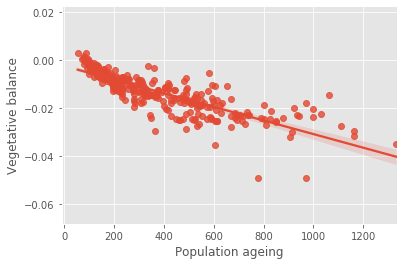

In [57]:
import seaborn as sns

sns.regplot(x='Population ageing',y='Vegetative balance',data=df_final)


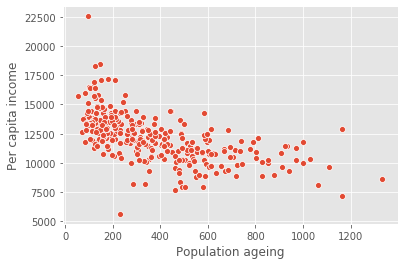

In [58]:
sns.scatterplot(x='Population ageing',y='Per capita income',data=df_final)

<h1><center>  </center></h1>

Let's examine the Foursquare data:

<h1><center>  </center></h1>

In [59]:
#checking the number of venues imported

print(galicia_venues.shape[0])

3231


In [60]:
#check the number of venues group by borough

#galicia_venues.groupby('Borough').count()

In [61]:
#check how many unique categories of venues are

print('There are {} uniques categories.'.format(len(galicia_venues['Venue Category'].unique())))

There are 217 uniques categories.


In [62]:
#check the distribution of venues in the boroughs

galicia_venues.groupby('Borough')['Venue'].count().describe()

count    304.000000
mean      10.628289
std       14.352125
min        1.000000
25%        4.000000
50%        6.000000
75%       10.000000
max      100.000000
Name: Venue, dtype: float64

In [63]:
#Venues of Galicia grouped by main category

galicia_venues.groupby('Main Category').count()

,INE Code,Borough,FQ borough Latitude,FQ borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Main Category,,,,,,,,
Arts & Entertainment,108,108,108,108,108,108,108,108
College & University,1,1,1,1,1,1,1,1
Food,1589,1589,1589,1589,1589,1589,1589,1589
Nightlife Spot,320,320,320,320,320,320,320,320
Outdoors & Recreation,625,625,625,625,625,625,625,625
Professional & Other Places,15,15,15,15,15,15,15,15
Shop & Service,294,294,294,294,294,294,294,294
Travel & Transport,279,279,279,279,279,279,279,279


<h1><center>  </center></h1>

If we plot the percentage of main categories in Galician boroughs: We can see that most of the venues are from "Food" (49.2%), following by "Outdoors and Recreation" (19.3%). "Nightlife Spot" is the third category (9.9%) and "Shop & Service" and "Travel & Transport" have similiar values (9.1% and 8.6% respectively).
"Arts & Entertainment" has a 3.3% and finally "College & University" and "Professional & Other Places" have less than 0.5%.

In the following section we will see how these percentages vary within Galician boroughs.

<h1><center>  </center></h1>

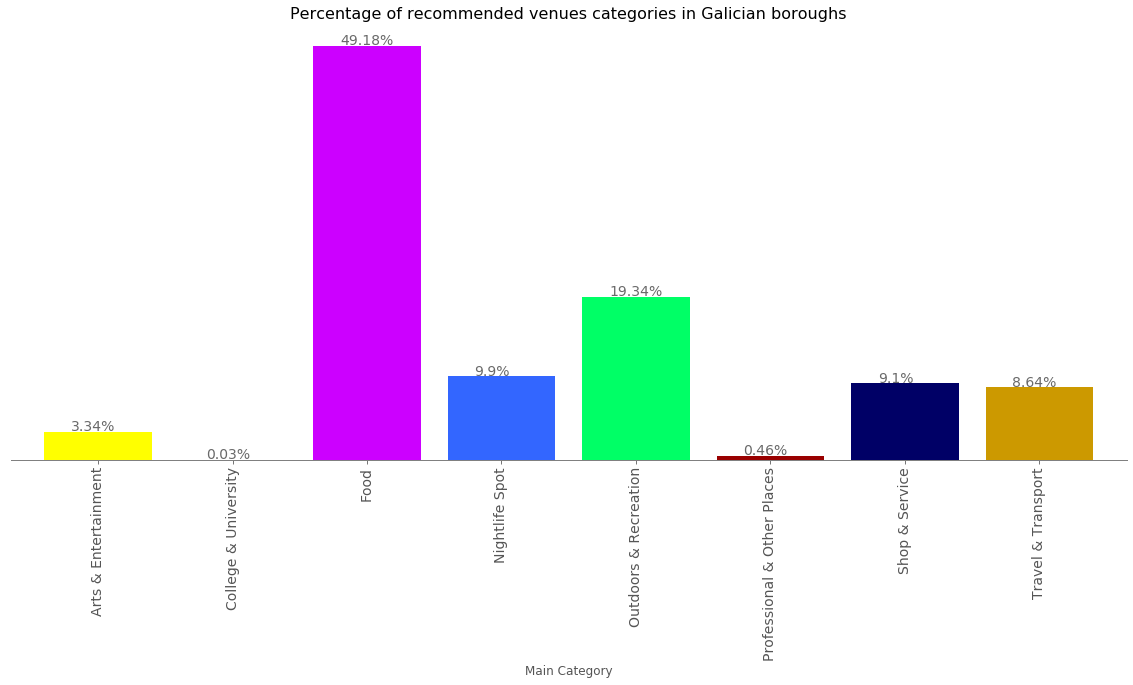

In [64]:
graph = galicia_venues.groupby('Main Category').count()['Venue Category']/galicia_venues.shape[0]


ax = graph.plot(kind='bar',figsize=(20, 8),color=['#FFFF00', '#FF6600', '#CC00FF','#3366FF','#00FF66','#990000','#000066','#CC9900'],grid=False,width=0.8,fontsize=14)


ax.set_title('Percentage of recommended venues categories in Galician boroughs',fontsize=16)
ax.yaxis.set_visible(False)
ax.set_facecolor('white')
ax.spines['bottom'].set_color('Grey')

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.20, i.get_height()+0.001, \
            str(round((i.get_height())*100,2))+'%', fontsize=14, color='dimgrey',
                rotation=0)
    
plt.show()     

### K-MEANS Clustering

<h1><center>  </center></h1>

A k-means algorithm is performed for clustering the Galician boroughs. Due to the difference in magnitudes between the indicators, we first make a normalization of these with StandardScaler. Then we use the silhouette score to determine the optimum value for the number of clusters.

<h1><center>  </center></h1>

In [65]:
#make the normalization

X=df_final[['Population','Per capita income','Population density','Population ageing','Vegetative balance','Unemployment rate']]

from sklearn.preprocessing import StandardScaler

Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet


array([[-0.13115827,  1.03063487, -0.18886827, -0.57402912, -0.10554086,
        -0.45399712],
       [ 0.93723196,  1.75522445,  0.58645824, -1.30154939,  1.8824667 ,
         0.39298878],
       [-0.27517858, -0.23470051, -0.30258283,  0.55722492, -0.51259675,
        -1.51646282],
       ...,
       [ 0.04330997,  0.38301455, -0.17171711, -0.83022753,  0.78270193,
         1.3925998 ],
       [-0.29437049, -0.41217103, -0.2866064 ,  0.73302737, -1.21996634,
        -0.88518198],
       [-0.31987873, -0.79554657, -0.27109987, -0.04531653,  0.58448353,
         0.56754923]])

In [66]:
#selecting the best k (number of clusters) with silhouette_score 

from sklearn.metrics import silhouette_score

for n_clusters in range(3, 10):
    clusterer = KMeans(n_clusters=n_clusters,random_state=0)
    preds = clusterer.fit_predict(Clus_dataSet)
    centers = clusterer.cluster_centers_
    score = silhouette_score (Clus_dataSet, preds, metric='euclidean')
    print(n_clusters, round(score,4))

3 0.3614
4 0.2594
5 0.2867
6 0.2987
7 0.2598
8 0.2637
9 0.2721


In [67]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 4, 1, 1, 4, 4, 1, 1, 2])

In [68]:
# add clustering labels to the dataframe
df_final.insert(0, 'Cluster Labels', kmeans.labels_)

df_final.head()

,Cluster Labels,INE Code,Borough,Population,Province,Latitude,Longitude,Per capita income,Population density,Population ageing,Vegetative balance,Unemployment,Unemployment rate
0,4,15001,Abegondo,5406,"Coruna, A",43.210443,-8.290324,14249.0,64.1,233.03,-0.013873,233.0,0.043100
1,1,15002,Ames,31793,"Coruna, A",42.890030,-8.651627,15727.0,394.1,54.67,0.002894,1791.0,0.056333
2,4,15003,Aranga,1849,"Coruna, A",43.218390,-8.015691,11668.0,15.7,510.37,-0.017307,49.0,0.026501
3,1,15004,Ares,5732,"Coruna, A",43.426330,-8.244039,13815.0,319.7,167.80,-0.004536,372.0,0.064899
4,1,15005,Arteixo,32262,"Coruna, A",43.309653,-8.500338,13811.0,347.8,81.88,0.001705,2040.0,0.063232


<h1><center>  </center></h1>

A Folium map is plotted representing the different clusters. In addition, in each popup we can consult the values of each borough and a graph of them compared to the average for Galicia.

<h1><center>  </center></h1>

In [69]:
# create map
import branca
from vincent import Bar


latitude = df_galicia_top['Latitude'].mean()
longitude = df_galicia_top['Longitude'].mean()


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters

rainbow = ['#154360','#CB4335','#F1C40F','#1af0d7','#0eed4d','#fa02cd']
names=['Small boroughs','Minor urban','Depopulated boroughs','Big cities','Primary sector boroughs','Urban']

population_mean=df_final['Population'].mean()
income_mean=df_final['Per capita income'].mean()
density_mean=df_final['Population density'].mean()
vegetative_mean=df_final['Vegetative balance'].mean()
unemployment_mean=df_final['Unemployment rate'].mean()
ageing_mean=df_final['Population ageing'].mean()

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,population,income,density,age,veg,une in zip(df_final['Latitude'], df_final['Longitude'], df_final['Borough'], df_final['Cluster Labels'],
          df_final['Population'],df_final['Per capita income'],df_final['Population density'],
          df_final['Population ageing'],df_final['Vegetative balance'],df_final['Unemployment rate']):
    
    df_plt=[]
    label = ("<h1>"+str(poi)+"</h1>" + "<br>"+"<h2>" ' Cluster ' + str(cluster) +": "+str(names[cluster])+ "</h2>"+"<br>"+' Population: ' +str(population)+"<br>"+' Income: ' 
            + str(income)+"<br>"+' Density: ' +str(density) +"<br>"+' Ageing: ' +str(age)+"<br>"+ ' Vegetative balance: ' +str(round(veg,4))
            + "<br>"+ ' Unemployment: ' +str(round(une*100,2))+"%"+"<br>"+'<br>'+'<center> <h4> Indicators comparing to Galicia mean (%) </h4> </center>')
    
    
    population_result = (population-population_mean)/population_mean*100
    income_result = (income-income_mean)/income_mean*100
    density_result = (density-density_mean)/density_mean*100
    vegetative_result = (veg-vegetative_mean)/-vegetative_mean*100
    ageing_result = (age-ageing_mean)/ageing_mean*100
    unemployment_result = (une-unemployment_mean)/unemployment_mean*100
    
    
    iframe = folium.IFrame(html=label, width=500, height=550)

    timevega = Bar({'Population':population_result,'Income':income_result,'Dens':density_result,'Veg':vegetative_result,
                    'Ageing':ageing_result,'Unempl':unemployment_result,}, width=300,
               height=150)
    
    timevega.axis_titles(x='Indicators', y='% Galician mean')
 
    timechart = folium.Vega(timevega.to_json(), width=100, height=100)
    
    label = folium.Popup(iframe, parse_html=False)
    
    f = branca.element.Figure()
    timechart.add_to(f)
    f.add_to(iframe)
    
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

## Results <a name="results"></a>

<h1><center>  </center></h1>

As a result from clustering we got six groups of boroughs that we are going to describe. Then we plot the Foursquare data for each cluster and compare them.

<h1><center>  </center></h1>

<h1><center>  </center></h1>

**Group 0: Small boroughs**

<br> There are 45 boroughs. This group corresponds to rural areas. They have small population and low values of per capita income. Their economic activity is very limited. Their population is quite old and the unemployment rate is high.

<h1><center>  </center></h1>

In [70]:
df_small_villages=df_final.loc[df_final['Cluster Labels'] == 0, df_final.columns[[2] +[3] + [7]+[8]+[9]+[10]+[12]]]

df_small_villages.describe()


,Population,Per capita income,Population density,Population ageing,Vegetative balance,Unemployment rate
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,2185.844444,10077.444444,37.848889,430.476222,-0.013335,0.067694
std,1505.690961,1298.975603,23.133306,148.620835,0.004689,0.014530
min,215.000000,5638.000000,4.100000,179.720000,-0.024911,0.042821
25%,1085.000000,9305.000000,21.900000,304.090000,-0.016667,0.058078
50%,1712.000000,10231.000000,33.000000,460.280000,-0.013178,0.063121
75%,2983.000000,11012.000000,43.900000,547.280000,-0.009906,0.075929
max,6074.000000,12512.000000,108.700000,741.540000,-0.002519,0.125581


<h1><center>  </center></h1>

**Group 1: Minor urban**

<br> There are 93 boroughs. This group can be considered almost as urban. They are economic engines of their areas (mainly rural). They have small population and medium values of per capita income, but their population is quite young and the unemployment rate is moderate.

<h1><center>  </center></h1>

In [71]:
df_minor_urban=df_final.loc[df_final['Cluster Labels'] == 1, df_final.columns[[2] +[3] + [7]+[8]+[9]+[10]+[12]]]
df_minor_urban.describe()

,Population,Per capita income,Population density,Population ageing,Vegetative balance,Unemployment rate
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,12144.795699,13503.903226,271.937634,147.502151,-0.004833,0.060261
std,8535.086911,1348.704363,211.952530,48.297096,0.003309,0.009686
min,644.000000,10744.000000,16.100000,54.670000,-0.012799,0.033252
25%,5732.000000,12599.000000,114.300000,114.620000,-0.006923,0.054544
50%,9977.000000,13371.000000,193.900000,138.460000,-0.004491,0.059750
75%,15841.000000,14263.000000,383.000000,170.220000,-0.002573,0.065396
max,39080.000000,17174.000000,1255.900000,324.300000,0.003225,0.087590


<h1><center>  </center></h1>

**Group 2: Depopulated boroughs**

<br> There are 75 boroughs. This group corresponds to rural areas. They are boroughs that lose a lot of population, very aged with many pensioners. Its economic activity is almost nil.

<h1><center>  </center></h1>

In [72]:
df_depopulation=df_final.loc[df_final['Cluster Labels'] == 2, df_final.columns[[2] +[3] + [7]+[8]+[9]+[10]+[12]]]
df_depopulation.describe()

,Population,Per capita income,Population density,Population ageing,Vegetative balance,Unemployment rate
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,1451.386667,10663.746667,15.674667,700.590933,-0.023987,0.038264
std,723.622884,1280.420308,8.049712,204.361784,0.006026,0.009380
min,316.000000,7148.000000,3.100000,364.830000,-0.048964,0.020249
25%,986.000000,9908.500000,9.800000,537.160000,-0.025370,0.031316
50%,1278.000000,10827.000000,14.900000,630.560000,-0.023835,0.036866
75%,1792.500000,11408.500000,20.100000,828.125000,-0.020490,0.044458
max,3735.000000,14260.000000,38.000000,1333.060000,-0.012939,0.066089


<h1><center>  </center></h1>

**Group 3: Big cities**

<br> There are 2 cities. They have the biggest population and highest density. They have the largest economic activity in Galicia. Here live more young people and the per capita income is higher, but the unemployment rate is also high.

<h1><center>  </center></h1>

In [73]:
df_big_cities=df_final.loc[df_final['Cluster Labels'] == 3, df_final.columns[[2] +[3] + [7]+[8]+[9]+[10]+[12]]]
df_big_cities.describe()

,Population,Per capita income,Population density,Population ageing,Vegetative balance,Unemployment rate
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,270537.500000,17416.500000,4517.200000,136.935000,-0.003393,0.070133
std,35109.973006,1454.518649,2674.984953,14.149207,0.000647,0.004751
min,245711.000000,16388.000000,2625.700000,126.930000,-0.003850,0.066774
25%,258124.250000,16902.250000,3571.450000,131.932500,-0.003621,0.068453
50%,270537.500000,17416.500000,4517.200000,136.935000,-0.003393,0.070133
75%,282950.750000,17930.750000,5462.950000,141.937500,-0.003164,0.071813
max,295364.000000,18445.000000,6408.700000,146.940000,-0.002935,0.073492


<h1><center>  </center></h1>

**Group 4: Primary sector boroughs**

<br> There are 90 boroughs. This group corresponds to rural areas. They have small population but their economy is sustained by primary activity (agriculture, livestock, fishing ...). Their population is not very old, per capita income is closer to minor urban areas, and the unemployment rate is very low.


<h1><center>  </center></h1>

In [74]:
df_primary_sector=df_final.loc[df_final['Cluster Labels'] == 4, df_final.columns[[2] +[3] + [7]+[8]+[9]+[10]+[12]]]
df_primary_sector.describe()

,Population,Per capita income,Population density,Population ageing,Vegetative balance,Unemployment rate
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,3611.144444,12531.644444,38.491111,328.268556,-0.012881,0.039751
std,2324.743516,1136.679753,24.267640,97.239947,0.004050,0.007968
min,641.000000,10118.000000,7.100000,169.450000,-0.024259,0.022187
25%,1865.000000,11675.250000,20.850000,252.920000,-0.015464,0.033740
50%,3081.500000,12530.000000,32.650000,318.360000,-0.012665,0.040238
75%,4608.750000,13313.500000,48.775000,400.380000,-0.010353,0.044741
max,14072.000000,15786.000000,118.300000,603.620000,-0.003120,0.055710


<h1><center>  </center></h1>

**Group 5: Urban boroughs**

<br> There are 6 boroughs. They are small cities. They have a big population and high density, but not as much as the big cities. They have economic activity well above average. Also here live more young people and the per capita income is higher, but the unemployment rate is moderate.

<h1><center>  </center></h1>

In [75]:
df_urban=df_final.loc[df_final['Cluster Labels'] == 5, df_final.columns[[2] +[3] + [7]+[8]+[9]+[10]+[12]]]
df_urban.describe()

,Population,Per capita income,Population density,Population ageing,Vegetative balance,Unemployment rate
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,80989.666667,17637.500000,711.333333,131.305000,-0.003858,0.062005
std,26059.593686,2655.465741,323.685648,33.094307,0.003164,0.009818
min,36075.000000,14852.000000,294.800000,97.560000,-0.009657,0.047928
25%,70306.000000,16442.500000,505.750000,109.582500,-0.004655,0.056017
50%,90144.500000,16848.000000,740.350000,123.335000,-0.002123,0.062573
75%,98022.000000,18030.500000,818.725000,143.695000,-0.001969,0.068780
max,105233.000000,22545.000000,1220.100000,188.120000,-0.001830,0.074275


<h1><center>  </center></h1>

Now we can see the box plots comparing the clusters for each indicator:

<h1><center>  </center></h1>

In [76]:
def create_box_chart(indicator,limit_1,limit_2,limit_3):

    fig=plt.figure()

    fig.suptitle(indicator, fontsize=20,color='blue')
    
    ax1=fig.add_subplot(1,6,1)
    ax2=fig.add_subplot(1,6,2)
    ax3=fig.add_subplot(1,6,3)
    ax4=fig.add_subplot(1,6,4)
    ax5=fig.add_subplot(1,6,5)
    ax6=fig.add_subplot(1,6,6)

    df_depopulation[indicator].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax1)
    df_small_villages[indicator].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax2)
    df_primary_sector[indicator].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax3)
    df_minor_urban[indicator].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax4)
    df_urban[indicator].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax5)
    df_big_cities[indicator].plot(kind='box',figsize=(20,10),color='blue',vert=True,ax=ax6)

    ax1.set_ylim([0,limit_1])
    ax2.set_ylim([0,limit_1])
    ax3.set_ylim([0,limit_1])
    ax4.set_ylim([0,limit_2])
    ax5.set_ylim([0,limit_2])
    ax6.set_ylim([0,limit_3])
    
    
    if indicator=='Vegetative balance':
        
        ax1.set_ylim([-0.04,limit_1])
        ax2.set_ylim([-0.04,limit_1])
        ax3.set_ylim([-0.04,limit_1])
        ax4.set_ylim([-0.04,limit_2])
        ax5.set_ylim([-0.04,limit_2])
        ax6.set_ylim([-0.04,limit_3])
    
    ax1.set_xlabel('Depopulated boroughs',color='black')
    ax2.set_xlabel('Small boroughs',color='black')
    ax3.set_xlabel('Primary sector boroughs',color='black')
    ax4.set_xlabel('Minor urban',color='black')
    ax5.set_xlabel('Urban',color='black')
    ax6.set_xlabel('Big cities',color='black')


    plt.show()

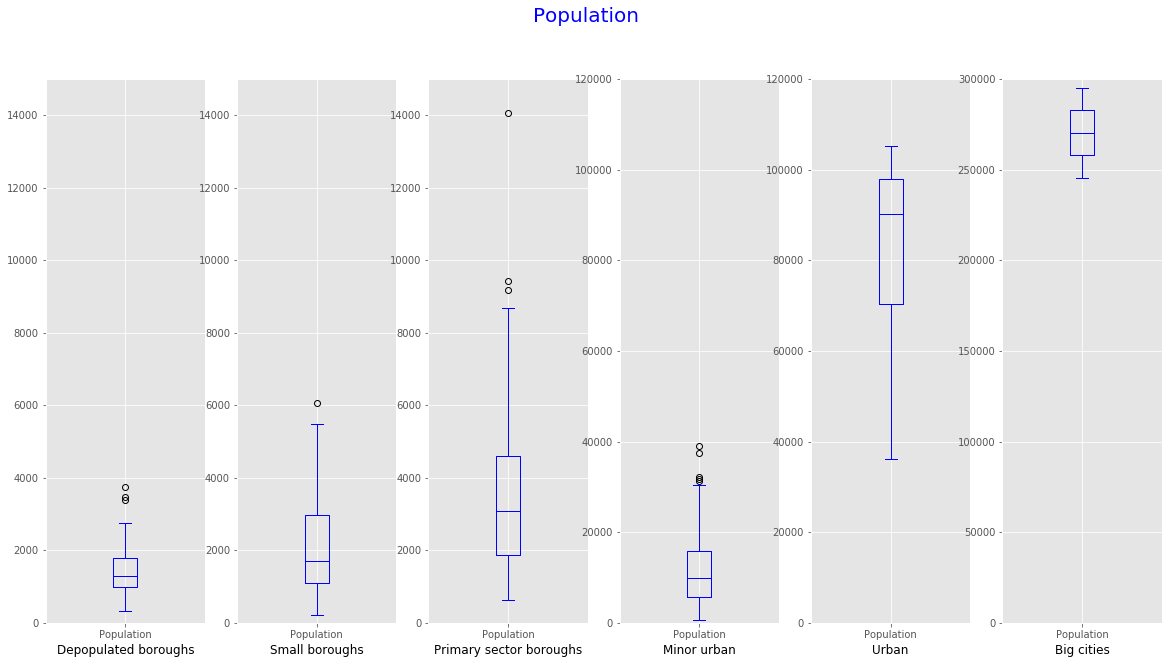

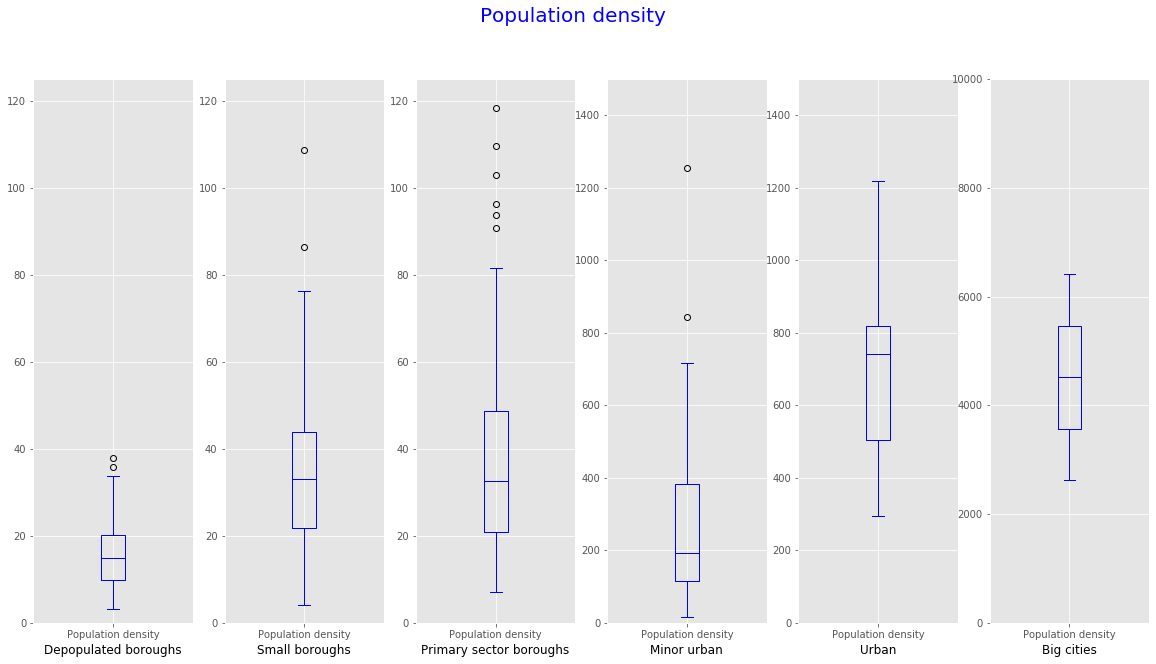

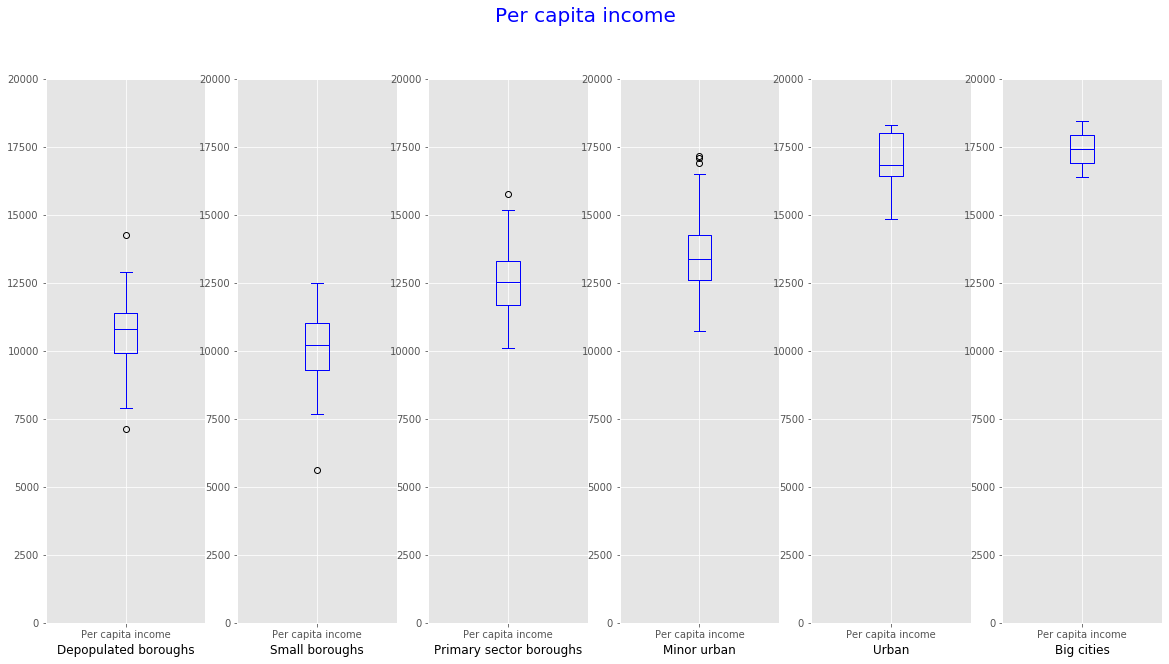

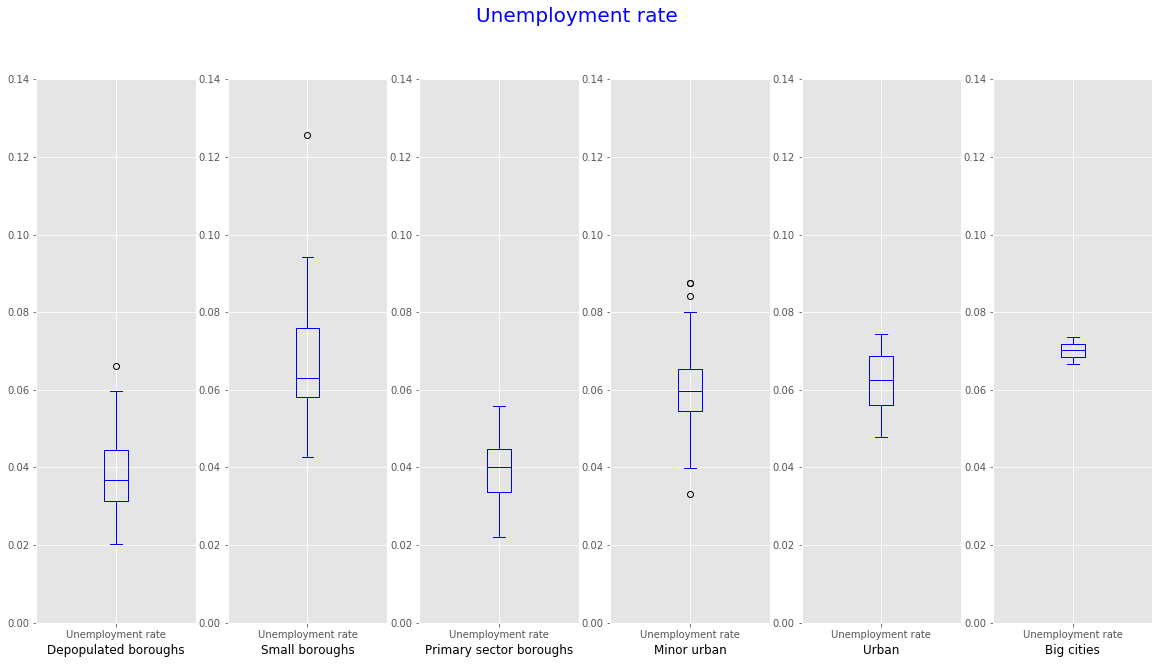

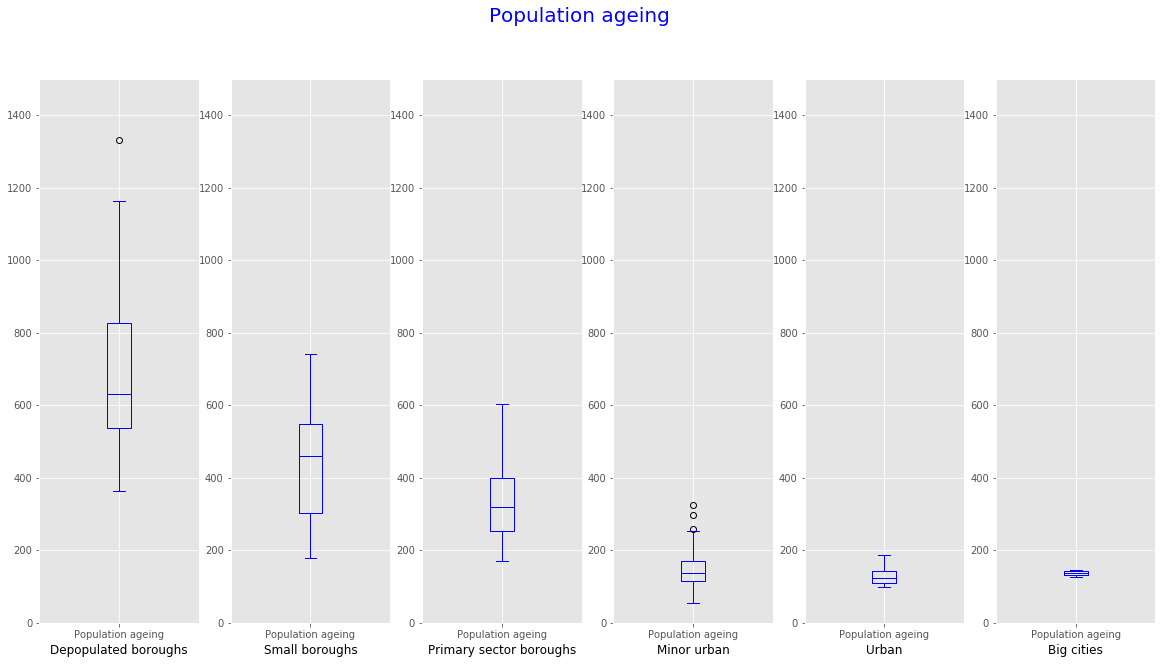

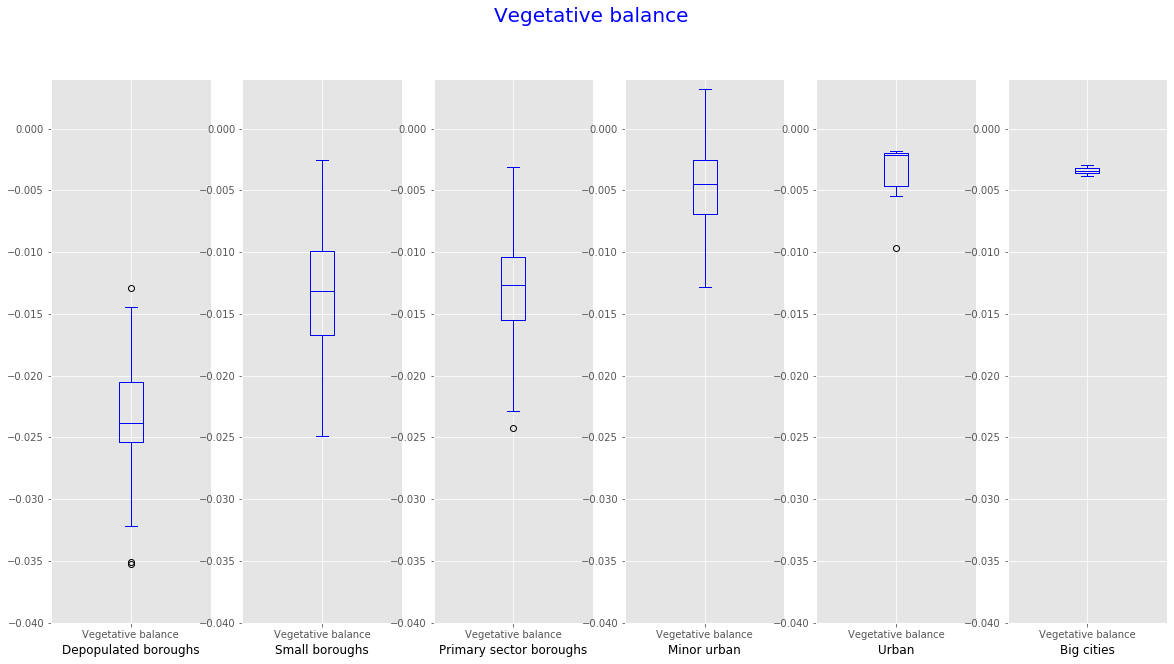

In [77]:
create_box_chart('Population',15000,120000,300000)
create_box_chart('Population density',125,1500,10000)
create_box_chart('Per capita income',20000,20000,20000)
create_box_chart('Unemployment rate',0.14,0.14,0.14)
create_box_chart('Population ageing',1500,1500,1500)
create_box_chart('Vegetative balance',0.004,0.004,0.004)

<h1><center>  </center></h1>

And finally a bar chart is created to have a clearer and more visual idea of the different clusters. To overcome the magnitude differences between indicators, their mean values are normalized. 

<h1><center>  </center></h1>

In [78]:
df_0=df_final.loc[df_final['Cluster Labels'] == 0, df_final.columns[[3] + [4]+[7]+[8]+[9]+[10]+[12]]].mean().tolist()
df_1=df_final.loc[df_final['Cluster Labels'] == 1, df_final.columns[[3] + [4]+[7]+[8]+[9]+[10]+[12]]].mean().tolist()
df_2=df_final.loc[df_final['Cluster Labels'] == 2, df_final.columns[[3] + [4]+[7]+[8]+[9]+[10]+[12]]].mean().tolist()
df_3=df_final.loc[df_final['Cluster Labels'] == 3, df_final.columns[[3] + [4]+[7]+[8]+[9]+[10]+[12]]].mean().tolist()
df_4=df_final.loc[df_final['Cluster Labels'] == 4, df_final.columns[[3] + [4]+[7]+[8]+[9]+[10]+[12]]].mean().tolist()
df_5=df_final.loc[df_final['Cluster Labels'] == 5, df_final.columns[[3] + [4]+[7]+[8]+[9]+[10]+[12]]].mean().tolist()

In [79]:
df_means= pd.DataFrame([df_0,df_1,df_2,df_3,df_4,df_5],columns=['Population','Per capita income','Population density','Population ageing','Vegetative balance','Unemployment rate'])

In [80]:
column_names_to_normalize = ['Population','Per capita income','Population density','Population ageing','Vegetative balance','Unemployment rate']
x = df_means[column_names_to_normalize].values
x_scaled = StandardScaler().fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df_means.index)
df_means[column_names_to_normalize] = df_temp


In [81]:
df_means.index=['Small boroughs','Minor urban','Depopulated boroughs','Big cities','Primary sector boroughs','Urban']
df_means.sort_values('Vegetative balance',inplace=True)


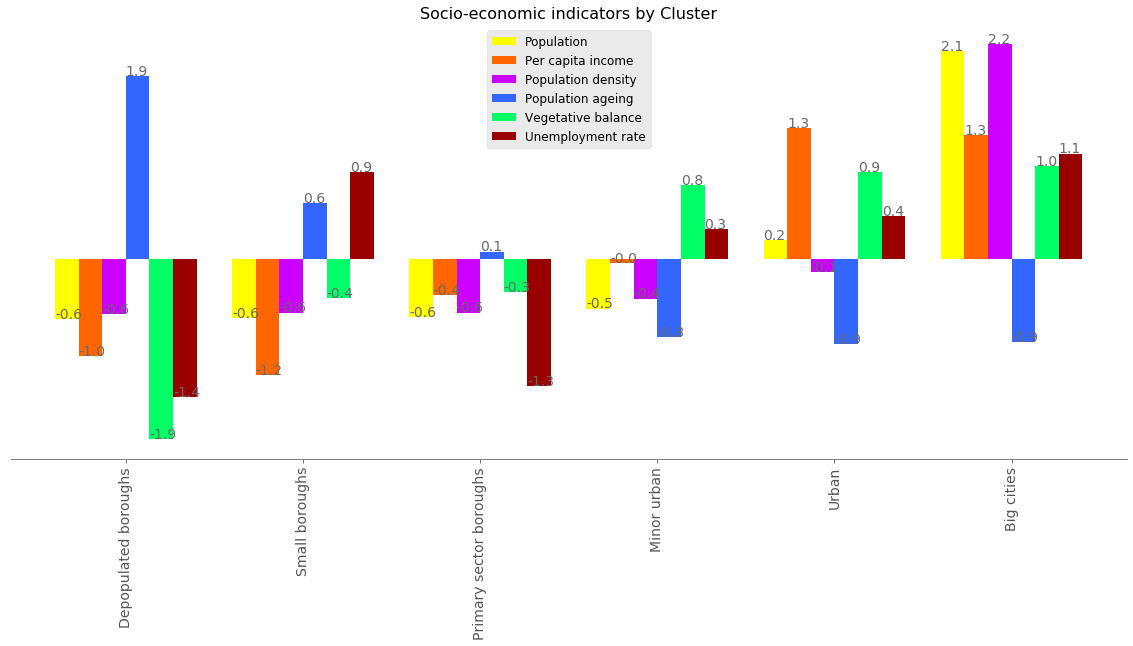

In [82]:
ax = df_means.plot(kind='bar',figsize=(20, 8),color=['#FFFF00', '#FF6600', '#CC00FF','#3366FF','#00FF66','#990000','#000066','#CC9900'],grid=False,width=0.8,fontsize=14)


ax.set_title('Socio-economic indicators by Cluster',fontsize=16)
ax.yaxis.set_visible(False)
ax.set_facecolor('white')
ax.legend(fontsize=12,loc='upper center',)
ax.spines['bottom'].set_color('Grey')

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+0.01, \
            str(round((i.get_height()), 1)  ), fontsize=14, color='dimgrey',
                rotation=0)
   
plt.show()     

<h1><center>  </center></h1>

Now let's see what happens with the Foursquare venues. If we group the venue categories by cluster, we can see that there are several trends. The clusters with more population and economic activity (urban areas) have a higher percentage of "Food" venues. It seems that there is a directly proportional relationship. But on the other hand, there is an inversely proportional relationship between the population and the "Outdoors & Recreation" venues. The rural areas has a higher percentage of recommended venues from this category. Also the "Travel & Transport" category has an inversely proportional relationship. This could be explained because the venues have been taken from the borough center: in less populated areas there are fewer recommended venues, and then these types of venues come up to the recommended ones. The "Nightlife Spot" category has a more similar percentage between clusters, being higher in big cities.

<h1><center>  </center></h1>

In [83]:
df_clusters = df_final.merge(galicia_grouped,how='left',on='INE Code')

In [84]:
df_clusters=df_clusters.drop(['INE Code','Borough_x','Borough_y','Population','Province','Latitude',
                             'Longitude','Per capita income','Population density','Population ageing','Vegetative balance','Unemployment','Unemployment rate'],axis=1)

In [85]:
df_clusters_grouped = df_clusters.groupby('Cluster Labels').mean()
df_clusters_grouped

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Cluster Labels,,,,,,,,
0,0.037329,0.000000,0.387587,0.043000,0.274484,0.025000,0.095725,0.136874
1,0.024517,0.000000,0.508285,0.089480,0.188482,0.001178,0.106985,0.081072
2,0.035771,0.000000,0.344711,0.089065,0.304881,0.005921,0.082608,0.137043
3,0.060000,0.000000,0.520000,0.175000,0.140000,0.010000,0.065000,0.030000
4,0.027123,0.000000,0.480963,0.113390,0.199844,0.004494,0.085920,0.088265
5,0.052709,0.001667,0.491469,0.100366,0.152395,0.003651,0.144915,0.052828


In [86]:
df_clusters_grouped.index=['Small boroughs','Minor urban','Depopulated boroughs','Big cities','Primary sector boroughs','Urban']
df_clusters_grouped.sort_values('Food',inplace=True)

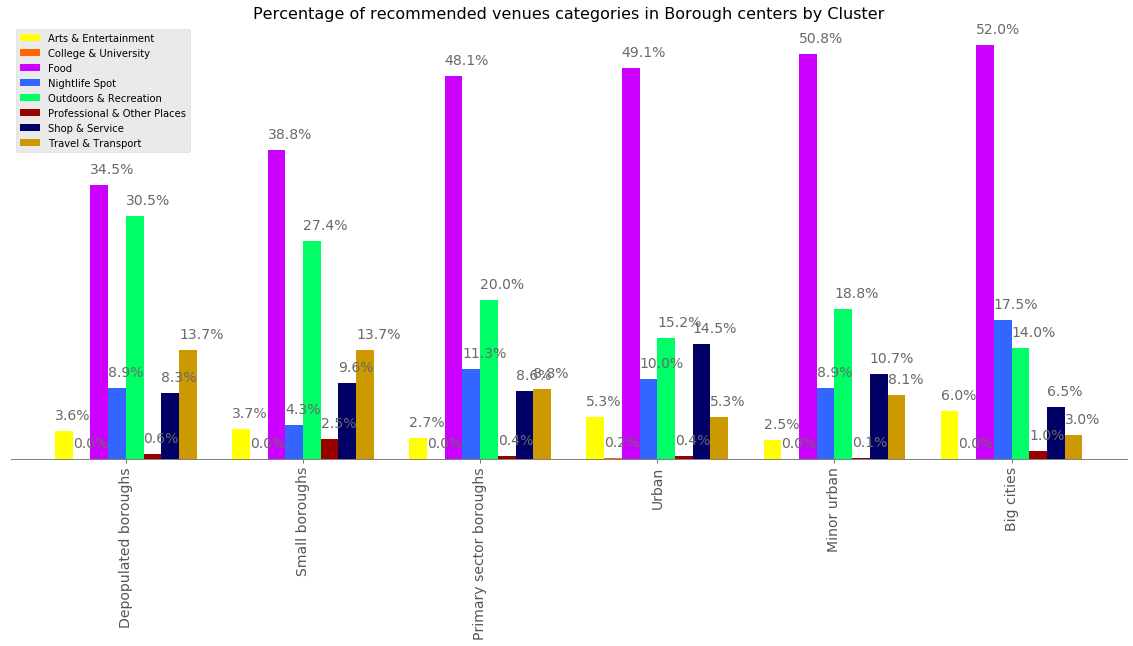

In [87]:
ax = df_clusters_grouped.plot(kind='bar',figsize=(20, 8),color=['#FFFF00', '#FF6600', '#CC00FF','#3366FF','#00FF66','#990000','#000066','#CC9900'],grid=False,width=0.8,fontsize=14)


ax.set_title('Percentage of recommended venues categories in Borough centers by Cluster',fontsize=16)
ax.yaxis.set_visible(False)
ax.set_facecolor('white')
ax.legend(fontsize=10)
ax.spines['bottom'].set_color('Grey')

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+0.015, \
            str(round((i.get_height()*100), 1))+'%', fontsize=14, color='dimgrey',
                rotation=0)
    
plt.show()     


## Discussion <a name="discussion"></a>

The main purpose of this study was to cluster the boroughs of Galicia based on several socio-economic indicators, and then analyze how the categories of Foursquare venues vary between the different clusters. To go further in this study, other indicators could be taken into account (e.g. education, business...) to see how the different boroughs would then be clustered. 

Only the main categories of Foursquare have been taken into account. Another idea to continue this work would be to break down each main category to have a broader detail of the venue distribution within each cluster.

## Conclusion <a name="conclusion"></a>

In this project the Galician boroughs were analysed based on several socio-economic indicators: population, density, per capita income, population ageing, vegetative balance and unemployment rate. With this data the boroughs have been clustered using the machine learning algorithm k-means into six groups.

The six clusters are well identified and described with their characteristics. There is a common trend towards aging. Three clear groups are big cities, small towns, and unpopulated areas. The differences between the other three groups are basically their population and ageing, and their economic activities.

 Also several trends between the indicators and the Foursquare venues were identified. The main idea is that in the most populated municipalities there are more recommended food places, while in the less populated there are more recreation areas.
 
This work can be useful to understand the demographic and economic distribution of Galician boroughs when offering services, infrastructures or any other kind of business.

